In [1]:
import os
import re

import pathlib
from pathlib import Path

import sqlite3

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
# Helper (support)
from support import input_helper

In [3]:
mpl.rcParams['figure.figsize'] = (16, 9)

In [4]:
ROOT_DIR = "RawData"

In [5]:
sns.set_style("ticks")
sns.color_palette("colorblind")
sns.set_context("notebook", font_scale=1)

* BE = Belgium
* FR = France
* EU = Europe
* FG = Flat Glass
* ArchFG = Architectural Flat Glass

# Upload Datasets

In [6]:
BE_data = input_helper.get_data('BE_RawData_VPython.xlsx', directory=ROOT_DIR)
FR_data = input_helper.get_data('FR_RawData_VPython.xlsx', directory=ROOT_DIR)
EU_data = input_helper.get_data('EU_RawData_VPython.xlsx', directory=ROOT_DIR)

In [7]:
print("BE_data, sheet names = \n {}\n".format(BE_data.sheet_names))
print("FR_data, sheet names = \n {}\n".format(FR_data.sheet_names))
print("EU_data, sheet names = \n {}\n".format(EU_data.sheet_names))

BE_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'FlatGlassInd_GlassInd', 'RawMat_GlassInd_ABS']

FR_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'RawMat_Intensity', 'RawMat_FlatGlass_ABS', 'emissions']

EU_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'EnergyUse', 'pollution', 'production costs']



# Flat glass production in France and Belgium

## Creating one dataframe for flat glass flows

In [8]:
# Creating a DataFrame only with production data
FR_Prod = FR_data.parse('prod').set_index('year')
BE_Prod = BE_data.parse('prod').set_index('year')

# Creating a new DataFrame for Belgian and French flat glass production
BE_FR_FGProd = pd.concat([FR_Prod['flat glass, kt'],
                          BE_Prod['flat glass, kt']],
                         axis=1, keys=['FR [kt]', 'BE [kt]'])

BE_FR_FGProd

,FR [kt],BE [kt]
year,,
1945,108.3,NaN
1946,173.8,NaN
1947,198.3,NaN
1948,220.2,NaN
1949,191.3,NaN
...,...,...
2016,NaN,NaN
2017,NaN,NaN
2018,NaN,NaN


In [9]:
# Creating a DataFrame with import and export data
FR_Imp = FR_data.parse('import').set_index('year')
FR_Exp = FR_data.parse('export').set_index('year')

BE_Imp = BE_data.parse('import').set_index('year')
BE_Exp = BE_data.parse('export').set_index('year')

In [10]:
# Creating a unique DataFrame for French and Belgian flat glass flows
BE_FR = pd.concat([FR_Prod['flat glass, kt'], BE_Prod['flat glass, kt'],
                   FR_Imp['flat glass, kt'], BE_Imp['flat glass, kt'],
                   FR_Exp['flat glass, kt'], BE_Exp['flat glass, kt']],
                  axis=1, keys=[('Production [kt]', 'France'),
                                ('Production [kt]', 'Belgium'),
                                ('Import [kt]', 'France'), 
                                ('Import [kt]', 'Belgium'),
                                ('Export [kt]', 'France'), 
                                ('Export [kt]', 'Belgium')],
                  names=['Info', 'Country']).stack()

BE_FR = BE_FR.unstack()

In [11]:
BE_FR

Info    Export [kt]             Import [kt]        Production [kt]       
Country     Belgium      France     Belgium France         Belgium France
year                                                                     
1945            NaN         NaN         NaN    NaN             NaN  108.3
1946            NaN         NaN         NaN    NaN             NaN  173.8
1947            NaN         NaN         NaN    NaN             NaN  198.3
1948            NaN         NaN         NaN    NaN             NaN  220.2
1949            NaN         NaN         NaN    NaN             NaN  191.3
...             ...         ...         ...    ...             ...    ...
2016     499.788799  300.836970  216.268865  370.0             NaN    NaN
2017     547.194746  333.308070  230.958655  401.0             NaN    NaN
2018     547.756244  349.183445  228.648795  355.0             NaN    NaN
2019     986.326016  451.417480  254.224505  352.0             NaN    NaN
2020            NaN         NaN         NaN  349.0             NaN    NaN

[76 rows x 6 columns]

## Production of flat glass

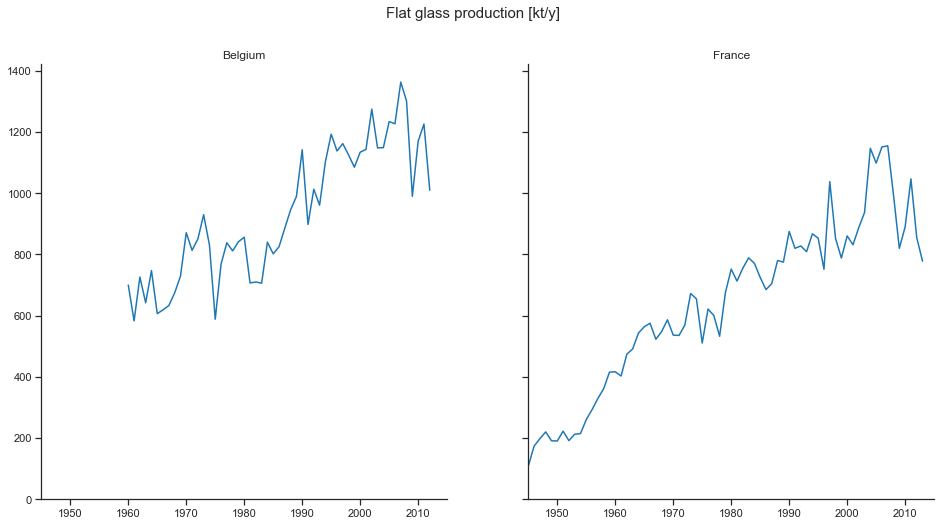

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, 
                         figsize=(16, 8), 
                         sharex=True, sharey=True)

for i, (ax, col) in enumerate(zip(axes.flatten(), 
                                  BE_FR['Production [kt]'].columns)):

    ax.plot(BE_FR['Production [kt]'].index, BE_FR['Production [kt]'][col])
    ax.set_title(col)
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    
fig.suptitle('Flat glass production [kt/y]', fontsize = 15)
sns.despine()
plt.show()

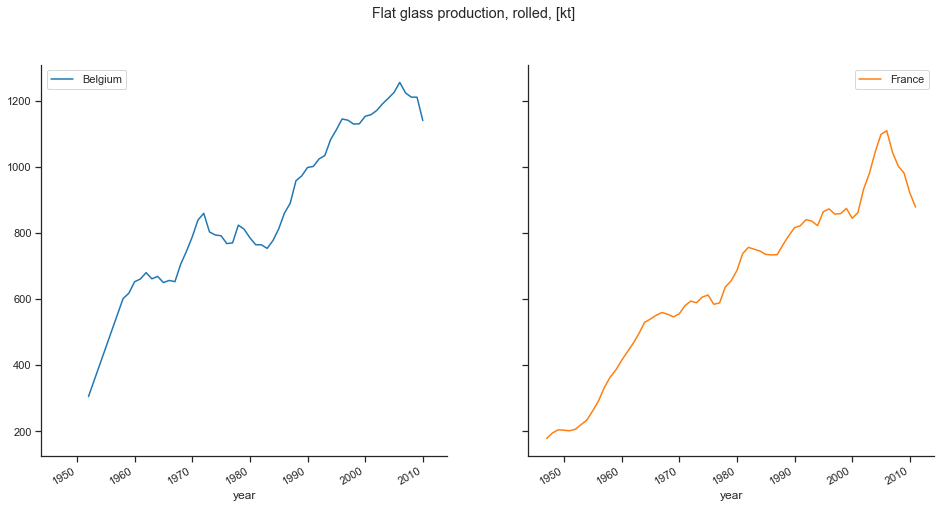

In [13]:
with sns.plotting_context("notebook"):
    # Linear interpolation for flat glass production
    #Rolling flat glass production according to a 5-year mean
    (BE_FR['Production [kt]']
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center = True)
     .mean()).plot(subplots=True, 
                   grid=False,
                   layout=(1, 2), 
                   figsize=(16, 8),
                   sharex=True, sharey=True,
                   title="Flat glass production, rolled, [kt]")
    
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    sns.despine()
    plt.show()

## Consumption of flat glass

<font color='red'>Watch out! For Belgium, data for import and export are not sufficiently reliable to provide a clear picture of flat glass consumption.</font>

<font color='red'>If a comprehensive set of data can be collected, it will be possible to better characterise the current stock.</font>

In [14]:
BE_FR = BE_FR.stack()

BE_FR['Import Ratio'] = BE_FR['Import [kt]'] / BE_FR['Production [kt]']
BE_FR['Export Ratio'] = BE_FR['Export [kt]'] / BE_FR['Production [kt]']

BE_FR = BE_FR.unstack()

In [15]:
# Interpolation for missing data
cols = [x for x in BE_FR.columns if x[0] in ['Import Ratio', 'Export Ratio']]

BE_FR[cols] = (BE_FR[cols].interpolate(method='linear'))

In [16]:
BE_FR.loc[1950:1960, cols]

Info    Import Ratio           Export Ratio          
Country      Belgium    France      Belgium    France
year                                                 
1950             NaN       NaN          NaN  0.292017
1951             NaN       NaN          NaN  0.280823
1952             NaN  0.005992          NaN  0.269629
1953             NaN  0.005329          NaN  0.259657
1954             NaN  0.049888          NaN  0.241980
1955             NaN  0.046431          NaN  0.199156
1956             NaN  0.044738          NaN  0.172535
1957             NaN  0.043044          NaN  0.145913
1958             NaN  0.041351          NaN  0.176946
1959             NaN  0.039658          NaN  0.207978
1960        0.020003  0.037964     0.659856  0.239011

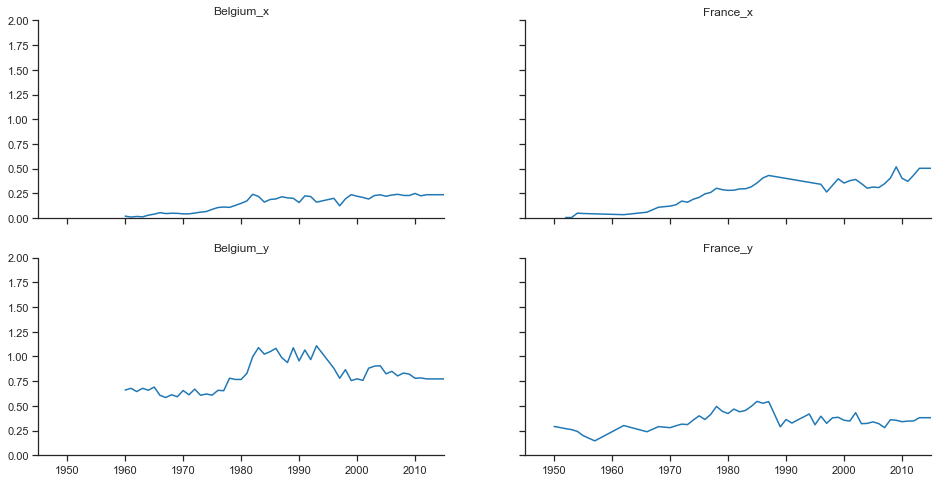

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, 
                         figsize=(16, 8), 
                         sharex=True, sharey=True)

data = pd.merge(BE_FR['Import Ratio'], BE_FR['Export Ratio'], 
                how='inner', on='year')

for i, (ax, col) in enumerate(zip(axes.flatten(), 
                                  data.columns)):
    ax.plot(data.index, data[col])
    ax.set_title(col)
    ax.set_xlim(1945,2015)
    ax.set_ylim(0,2)

sns.despine()
plt.show()

In [18]:
data

Country,Belgium_x,France_x,Belgium_y,France_y
year,,,,
1945,NaN,NaN,NaN,NaN
1946,NaN,NaN,NaN,NaN
1947,NaN,NaN,NaN,NaN
1948,NaN,NaN,NaN,NaN
1949,NaN,NaN,NaN,NaN
...,...,...,...,...
2016,0.236622,0.503856,0.772944,0.380505
2017,0.236622,0.503856,0.772944,0.380505
2018,0.236622,0.503856,0.772944,0.380505


In [19]:
BE_FR = BE_FR.stack()

BE_FR['Consumption [kt]'] = (BE_FR['Production [kt]']
                                         + BE_FR['Import Ratio'] 
                                         * BE_FR['Production [kt]']
                                         - BE_FR['Export Ratio'] 
                                         * BE_FR['Production [kt]'])

BE_FR = BE_FR.unstack()

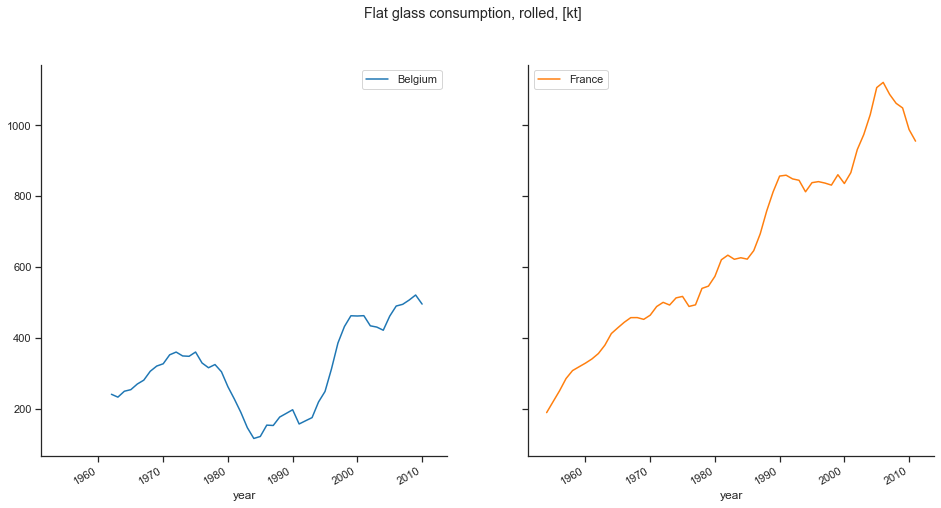

In [20]:
with sns.plotting_context("notebook"):
    # Linear interpolation for flat glass consumption
    #Rolling flat glass production according to a 5-year mean
    (BE_FR['Consumption [kt]']
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center = True)
     .mean()).plot(subplots=True, 
                   grid=False,
                   layout=(1, 2), 
                   figsize=(16, 8),
                   sharex=True, sharey=True,
                   title="Flat glass consumption, rolled, [kt]")
    
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    sns.despine()
    plt.show()

## Production of architectural flat glass

In [21]:
# Share of building glass in the French production of flat glass

ShareFR = FR_Prod[['bldg glass/flat glass, %']].dropna()

print(ShareFR.isnull().sum())
ShareFR

bldg glass/flat glass, %    0
dtype: int64


,"bldg glass/flat glass, %"
year,
1947,0.90
1952,0.80
1962,0.68
1968,0.50
1980,0.50
1994,0.50
2002,0.52
2004,0.49


In [22]:
# Estimating parameters a and b of the regression lines

ShareFR['Trend1'] = ShareFR['bldg glass/flat glass, %'][:4]
ShareFR['Trend2'] = ShareFR['bldg glass/flat glass, %'][-5:]

ShareFR = ShareFR.reset_index()

x1 = list(ShareFR['year'][:4])
y1 = list(ShareFR['Trend1'][:4])
a1, b1 = np.polyfit(x1, y1, 1)

x2 = list(ShareFR['year'][-5:])
y2 = list(ShareFR['Trend2'][-5:])
a2, b2 = np.polyfit(x2, y2, 1)

ShareFR = ShareFR.set_index('year')

# Point of intersection of the two regression lines
xi = (b1-b2) / (a2-a1)
print(f'Approximate year of rate change: {xi:.0f}')

Approximate year of rate change: 1970


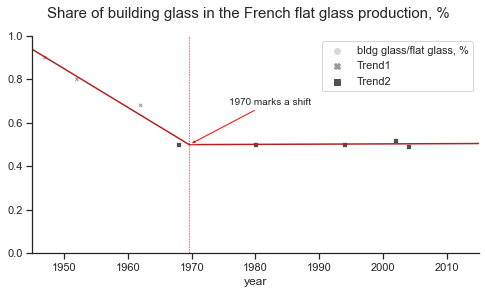

In [23]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.scatterplot(data=ShareFR, s=25, palette='Greys', ax=ax)

A = np.linspace(1945,xi)
ax.plot(A, a1*A+b1, color='firebrick')
B = np.linspace(xi,2020)
ax.plot(B, a2*B+b2, color='firebrick')

ax.axvline(xi ,linestyle='--', c='r', linewidth=0.5)

ax.annotate('1970 marks a shift', xy=(xi, a1*xi+b1), xycoords='data',
            xytext=(40, 40), textcoords='offset points', fontsize = 10,
            arrowprops=dict(arrowstyle='simple', facecolor='r'))

ax.set_ylim(0,1)
ax.set_xlim(1945,2015)
fig.suptitle('Share of building glass in the French flat glass production, %', 
             fontsize = 15)

sns.despine()
plt.show()

In [24]:
# Update dataset according to regression lines
BldgShare = FR_Prod[['bldg glass/flat glass, %']]

BldgShare = BldgShare.reset_index()

BldgShare.loc[(BldgShare['year'] < xi), 'bldg glass/flat glass, %'] \
    = round(a1 * BldgShare['year'] + b1, 2)

BldgShare.loc[(BldgShare['year'] >= xi), 'bldg glass/flat glass, %'] \
    = round(a2 * BldgShare['year'] + b2, 2)

BldgShare = BldgShare.set_index('year')
BldgShare

,"bldg glass/flat glass, %"
year,
1945,0.94
1946,0.92
1947,0.90
1948,0.88
1949,0.87
...,...
2016,0.50
2017,0.51
2018,0.51


In [25]:
# Estimate architectural flat glass production in France and Belgium
for country in BE_FR['Production [kt]'].columns:
    BE_FR[('Architectural glass production [kt]', country)] = (
        BE_FR[('Production [kt]', country)]
        * BldgShare['bldg glass/flat glass, %']
    )

In [26]:
BE_FR

Info    Export [kt]             Import [kt]        Production [kt]         \
Country     Belgium      France     Belgium France         Belgium France   
year                                                                        
1945            NaN         NaN         NaN    NaN             NaN  108.3   
1946            NaN         NaN         NaN    NaN             NaN  173.8   
1947            NaN         NaN         NaN    NaN             NaN  198.3   
1948            NaN         NaN         NaN    NaN             NaN  220.2   
1949            NaN         NaN         NaN    NaN             NaN  191.3   
...             ...         ...         ...    ...             ...    ...   
2016     499.788799  300.836970  216.268865  370.0             NaN    NaN   
2017     547.194746  333.308070  230.958655  401.0             NaN    NaN   
2018     547.756244  349.183445  228.648795  355.0             NaN    NaN   
2019     986.326016  451.417480  254.224505  352.0             NaN    NaN   
2020            NaN         NaN         NaN  349.0             NaN    NaN   

Info    Import Ratio           Export Ratio           Consumption [kt]         \
Country      Belgium    France      Belgium    France          Belgium France   
year                                                                            
1945             NaN       NaN          NaN       NaN              NaN    NaN   
1946             NaN       NaN          NaN       NaN              NaN    NaN   
1947             NaN       NaN          NaN       NaN              NaN    NaN   
1948             NaN       NaN          NaN       NaN              NaN    NaN   
1949             NaN       NaN          NaN       NaN              NaN    NaN   
...              ...       ...          ...       ...              ...    ...   
2016        0.236622  0.503856     0.772944  0.380505              NaN    NaN   
2017        0.236622  0.503856     0.772944  0.380505              NaN    NaN   
2018        0.236622  0.503856     0.772944  0.380505              NaN    NaN   
2019        0.236622  0.503856     0.772944  0.380505              NaN    NaN   
2020        0.236622  0.503856     0.772944  0.380505              NaN    NaN   

Info    Architectural glass production [kt]           
Country                             Belgium   France  
year                                                  
1945                                    NaN  101.802  
1946                                    NaN  159.896  
1947                                    NaN  178.470  
1948                                    NaN  193.776  
1949                                    NaN  166.431  
...                                     ...      ...  
2016                                    NaN      NaN  
2017                                    NaN      NaN  
2018                                    NaN      NaN  
2019                                    NaN      NaN  
2020                                    NaN      NaN  

[76 rows x 14 columns]

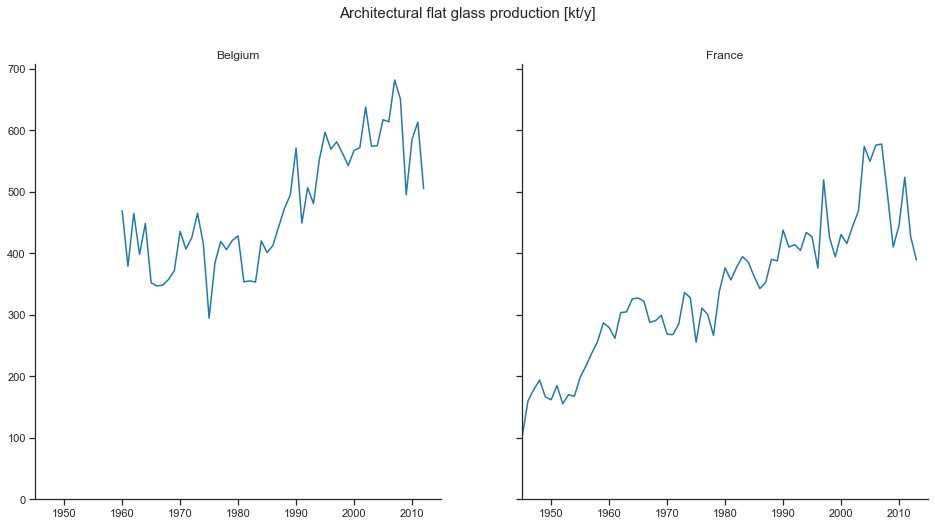

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, 
                         figsize=(16, 8), 
                         sharex=True, sharey=True)

for i, (ax, col) in enumerate(zip(axes.flatten(), 
                                  BE_FR['Architectural glass production [kt]']
                                  .columns)):

    ax.plot(BE_FR['Architectural glass production [kt]'].index, 
            BE_FR['Architectural glass production [kt]'][col])
    ax.set_title(col)
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    
fig.suptitle('Architectural flat glass production [kt/y]', fontsize = 15)
sns.despine()
plt.show()

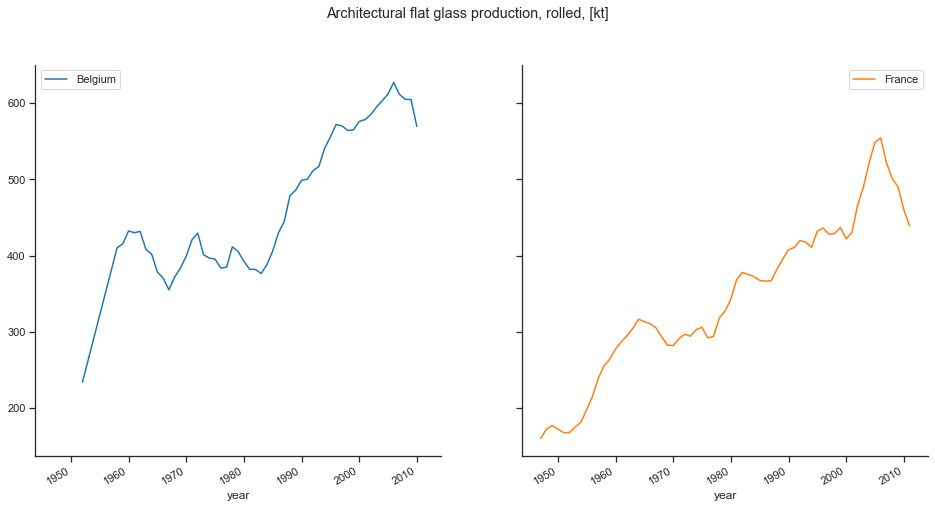

In [28]:
with sns.plotting_context("notebook"):
    # Linear interpolation for flat glass consumption
    #Rolling flat glass production according to a 5-year mean
    (BE_FR['Architectural glass production [kt]']
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center = True)
     .mean()).plot(subplots=True, 
                   grid=False,
                   layout=(1, 2), 
                   figsize=(16, 8),
                   sharex=True, sharey=True,
                   title="Architectural flat glass production, rolled, [kt]")
    
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    sns.despine()
    plt.show()

## Consumption of architectural flat glass

In [29]:
BE_FR = BE_FR.stack()

BE_FR['Architectural glass consumption [kt]'] = (
    BE_FR['Architectural glass production [kt]']
    + BE_FR['Import Ratio'] * BE_FR['Architectural glass production [kt]']
    - BE_FR['Export Ratio'] * BE_FR['Architectural glass production [kt]'])

BE_FR = BE_FR.unstack()

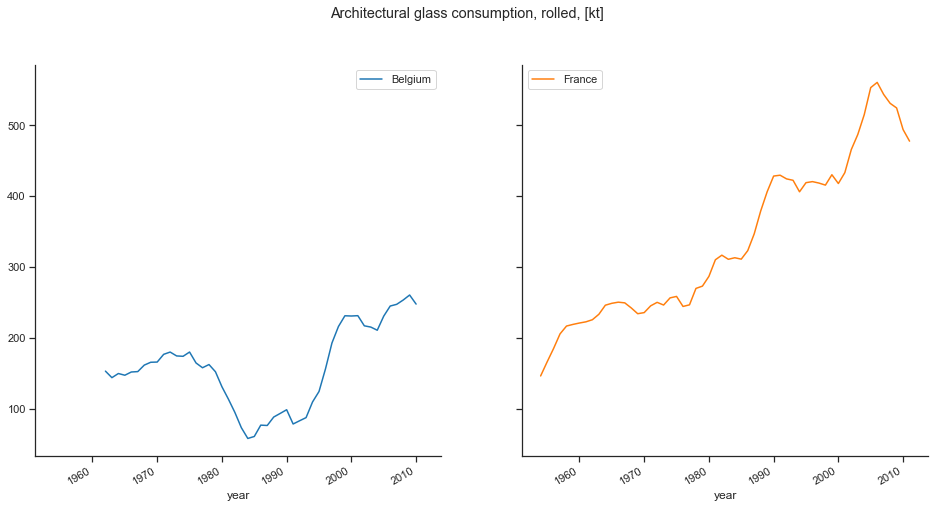

In [30]:
with sns.plotting_context("notebook"):
    # Linear interpolation for flat glass consumption
    #Rolling flat glass production according to a 5-year mean
    (BE_FR['Architectural glass consumption [kt]']
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center = True)
     .mean()).plot(subplots=True, 
                   grid=False,
                   layout=(1, 2), 
                   figsize=(16, 8),
                   sharex=True, sharey=True,
                   title="Architectural glass consumption, rolled, [kt]")
    
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    sns.despine()
    plt.show()

# The CO2 emissions of the flat glass industry

## Carbon intensity of the flat glass production process

In [31]:
# Creating a DataFrame only with CO2 emission data
Emissions = FR_data.parse('emissions').set_index('year')

CO2_Intensity = Emissions[['CO2 glass ind, kg/t']].copy()
CO2_Intensity.rename(columns={'CO2 glass ind, kg/t':'CO2 [kg/t]'}, 
           inplace=True)

CO2_Intensity.dropna()

,CO2 [kg/t]
year,
1947,2100.0
1950,2050.0
1960,1725.0
1965,1525.0
1970,1340.0
1975,1075.0
1980,900.0
1985,800.0
1990,690.0


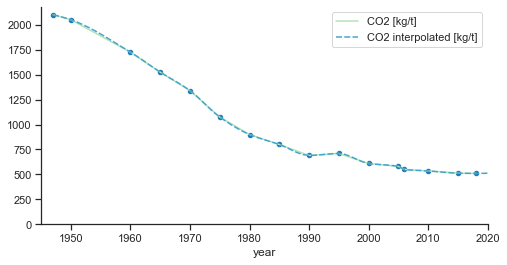

In [32]:
CO2_Intensity['CO2 interpolated [kg/t]'] = (
    CO2_Intensity['CO2 [kg/t]'].interpolate('pchip')
)

fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(data=CO2_Intensity, palette="GnBu")

ax.scatter(x=CO2_Intensity.index, y=CO2_Intensity['CO2 [kg/t]'],
           s=20)

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Absolute CO2 emissions since 1945

In [33]:
# Estimating the CO2 emission related to flat glass production
for country in BE_FR['Production [kt]'].columns:
    BE_FR[('CO2, flat glass [kt]', country)] = (
        BE_FR[('Production [kt]', country)]
        * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
    )

In [34]:
# Estimating the CO2 emission related to architectural flat glass production
for country in BE_FR['Architectural glass production [kt]'].columns:
    BE_FR[('CO2, architectural glass [kt]', country)] = (
        BE_FR[('Architectural glass production [kt]', country)]
        * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
    )

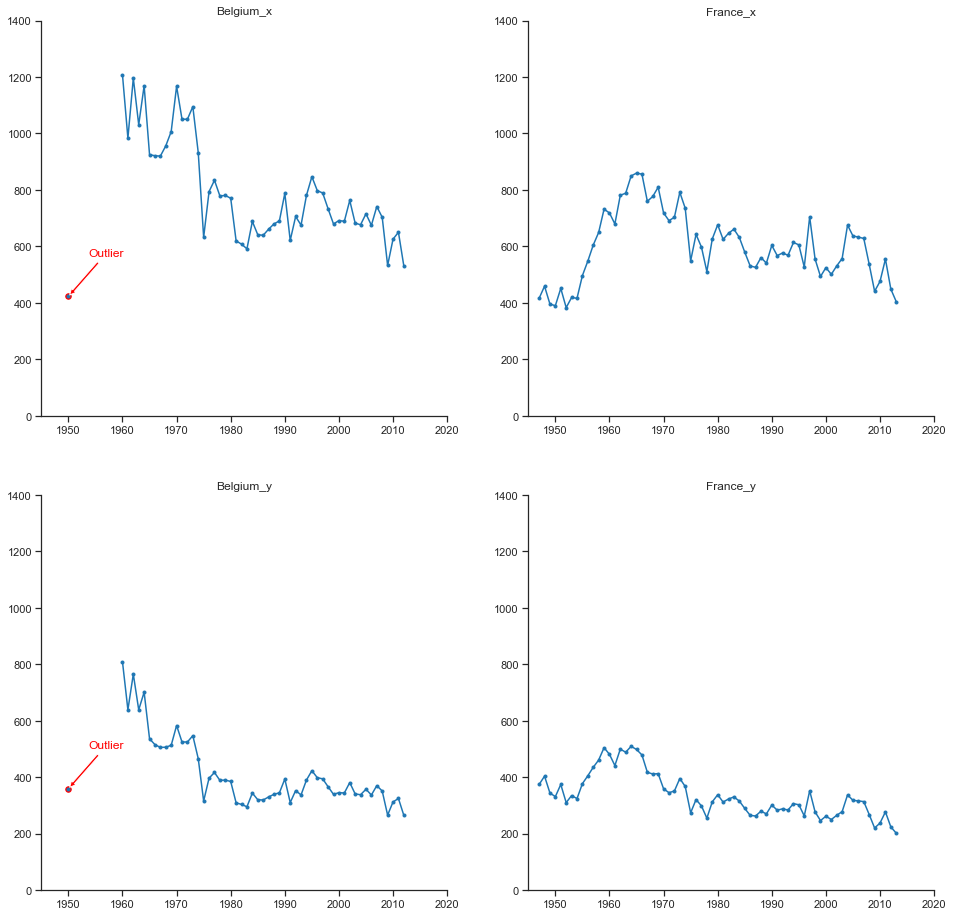

In [35]:
# Ploting the CO2 emission related to flat glass production
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

data = pd.merge(BE_FR['CO2, flat glass [kt]'], 
                BE_FR['CO2, architectural glass [kt]'], 
                how='inner', on='year')

for i, (ax, col) in enumerate(zip(axes.flatten(), 
                                  data.columns)):

    ax.plot(data.index, 
            data[col], 
            marker=".")
    
    ax.set_title(col)
    ax.set_xlim(1945,2020)
    ax.set_ylim(0,1400)
    
    # Annotate the outlier
    if 'Belgium' in col:
        x = 1950
        y = data.loc[1950, col]
        ax.scatter(x=x, y=y, c='r', marker='o', s=30)
        ax.annotate("Outlier", xy=(x,y), xycoords='data', color='r',
                    xytext=(20,40), textcoords='offset points',
                    arrowprops=dict(arrowstyle='simple', facecolor='r'))
    
sns.despine()
plt.show()

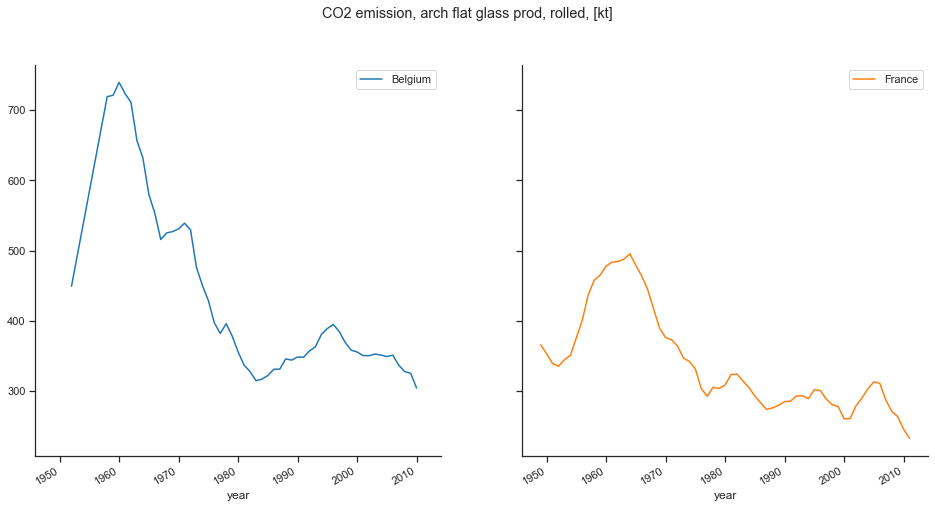

In [36]:
#Rolling and ploting the CO2 emission related to architectural glass prod
with sns.plotting_context("notebook"):
    #Rolling flat glass production according to a 5-year mean
    (BE_FR['CO2, architectural glass [kt]']
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center = True)
     .mean()).plot(subplots=True, 
                   grid=False,
                   layout=(1, 2), 
                   figsize=(16, 8),
                   sharex=True, sharey=True,
                   title=("CO2 emission, arch flat glass prod, rolled, [kt]")
                  )
    
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    sns.despine()
    plt.show()

## Base 100 analysis

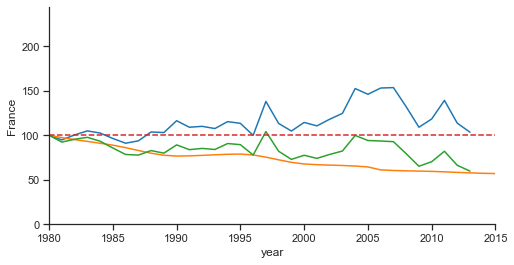

In [37]:
# Base 100 = 1980
FGProd_diff = (100 * BE_FR['Production [kt]'] 
               / BE_FR['Production [kt]'].loc[1980]
              )

CO2Intensity_diff = 100 * CO2_Intensity / CO2_Intensity.loc[1980]

CO2ABS_diff = (100 * BE_FR['CO2, flat glass [kt]'] 
               / BE_FR['CO2, flat glass [kt]'].loc[1980]
              )

# Plotting production, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(data = FGProd_diff, 
             x = FGProd_diff.index, 
             y = 'France',
             ax=ax)

ax.plot(CO2Intensity_diff.index, 
        CO2Intensity_diff['CO2 interpolated [kg/t]'])
ax.plot(CO2ABS_diff.index, 
        CO2ABS_diff['France'])

ax.plot([1980, 2015], [100, 100], '--')

ax.set_xlim(1980,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

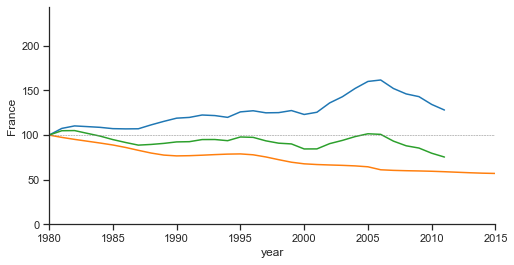

In [38]:
# Base 100 = 1980
FGProd_diff = (100 * (BE_FR['Production [kt]']
                      .interpolate(method="linear", limit_area='inside')
                     .rolling(5, center=True).mean()) 
               / (BE_FR['Production [kt]']
                  .interpolate(method="linear", limit_area='inside')
                  .rolling(5, center = True).mean()).loc[1980])

CO2Intensity_diff = 100 * CO2_Intensity / CO2_Intensity.loc[1980]

CO2ABS_diff = (100 * (BE_FR['CO2, flat glass [kt]']
                     .interpolate(method="linear", limit_area='inside')
                     .rolling(5, center = True).mean()) 
               / (BE_FR['CO2, flat glass [kt]']
                     .interpolate(method="linear", limit_area='inside')
                     .rolling(5, center=True).mean().loc[1980])
              )

# Plotting production, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(data=FGProd_diff, 
             x=FGProd_diff.index, 
             y='France',
             ax=ax)

ax.plot(CO2Intensity_diff.index, 
        CO2Intensity_diff['CO2 interpolated [kg/t]'])
ax.plot(CO2ABS_diff.index, 
        CO2ABS_diff['France'])

ax.plot([1980, 2015], [100, 100], '--', c='grey', linewidth=0.5)

ax.set_xlim(1980,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

# The raw materials of the flat glass industry

## Material intensity since 1945

In [39]:
# Creating a DataFrame with material intensity
MatIntensity = FR_data.parse('RawMat_Intensity').set_index('year')

In [40]:
# Interpolating the raw material intensity dataset
MatIntensity = MatIntensity.interpolate(method='pchip',
                                         limit_direction='forward')

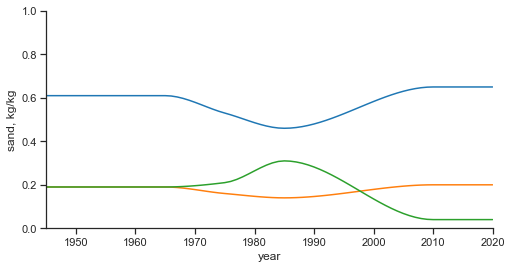

In [41]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(data=MatIntensity, 
             x=MatIntensity.index, 
             y='sand, kg/kg',
             ax=ax)

ax.plot(MatIntensity.index, 
        MatIntensity['sodium carb., kg/kg'])
ax.plot(MatIntensity.index, 
        MatIntensity['ext. cullet, kg/kg'])

ax.set_xlim(1945,2020)
ax.set_ylim(0,1)
sns.despine()
plt.show()

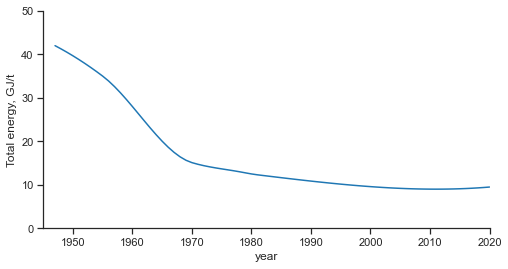

In [42]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(data = MatIntensity, 
             x = MatIntensity.index, 
             y = 'Total energy, GJ/t',
             ax=ax)

ax.set_xlim(1945,2020)
ax.set_ylim(0,50)
sns.despine()
plt.show()

## Use of raw materials in the production of flat glass

In [43]:
# Internal cullet
for country in BE_FR['Production [kt]'].columns:
    BE_FR[('Int. cullet, flat glass [kt]', country)] = (
        BE_FR[('Production [kt]', country)]
        * MatIntensity['int. cullet, kg/kg']
    )
    
# External cullet
for country in BE_FR['Production [kt]'].columns:
    BE_FR[('Ext. cullet, flat glass [kt]', country)] = (
        BE_FR[('Production [kt]', country)]
        * MatIntensity['ext. cullet, kg/kg']
    )
    
# Sand
for country in BE_FR['Production [kt]'].columns:
    BE_FR[('Sand, flat glass [kt]', country)] = (
        BE_FR[('Production [kt]', country)]
        * MatIntensity['sand, kg/kg']
    )
    
# Socium carbonate
for country in BE_FR['Production [kt]'].columns:
    BE_FR[('Sodium carbonate, flat glass [kt]', country)] = (
        BE_FR[('Production [kt]', country)]
        * MatIntensity['sodium carb., kg/kg']
    )
    
# Sodium sulfate
for country in BE_FR['Production [kt]'].columns:
    BE_FR[('Sodium sulfate, flat glass [kt]', country)] = (
        BE_FR[('Production [kt]', country)]
        * MatIntensity['sodium sulfate, kg/kg']
    )
    
# Limestone
for country in BE_FR['Production [kt]'].columns:
    BE_FR[('Limestone, flat glass [kt]', country)] = (
        BE_FR[('Production [kt]', country)]
        * MatIntensity['limestone, kg/kg']
    )
    
#Dolomite
for country in BE_FR['Production [kt]'].columns:
    BE_FR[('Dolomite, flat glass [kt]', country)] = (
        BE_FR[('Production [kt]', country)]
        * MatIntensity['dolomite, kg/kg']
    )
    
# Feldspar
for country in BE_FR['Production [kt]'].columns:
    BE_FR[('Feldspar, flat glass [kt]', country)] = (
        BE_FR[('Production [kt]', country)]
        * MatIntensity['feldspar, kg/kg']
    )   

In [ ]:
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

num=0
for column in df.drop('x', axis=1):


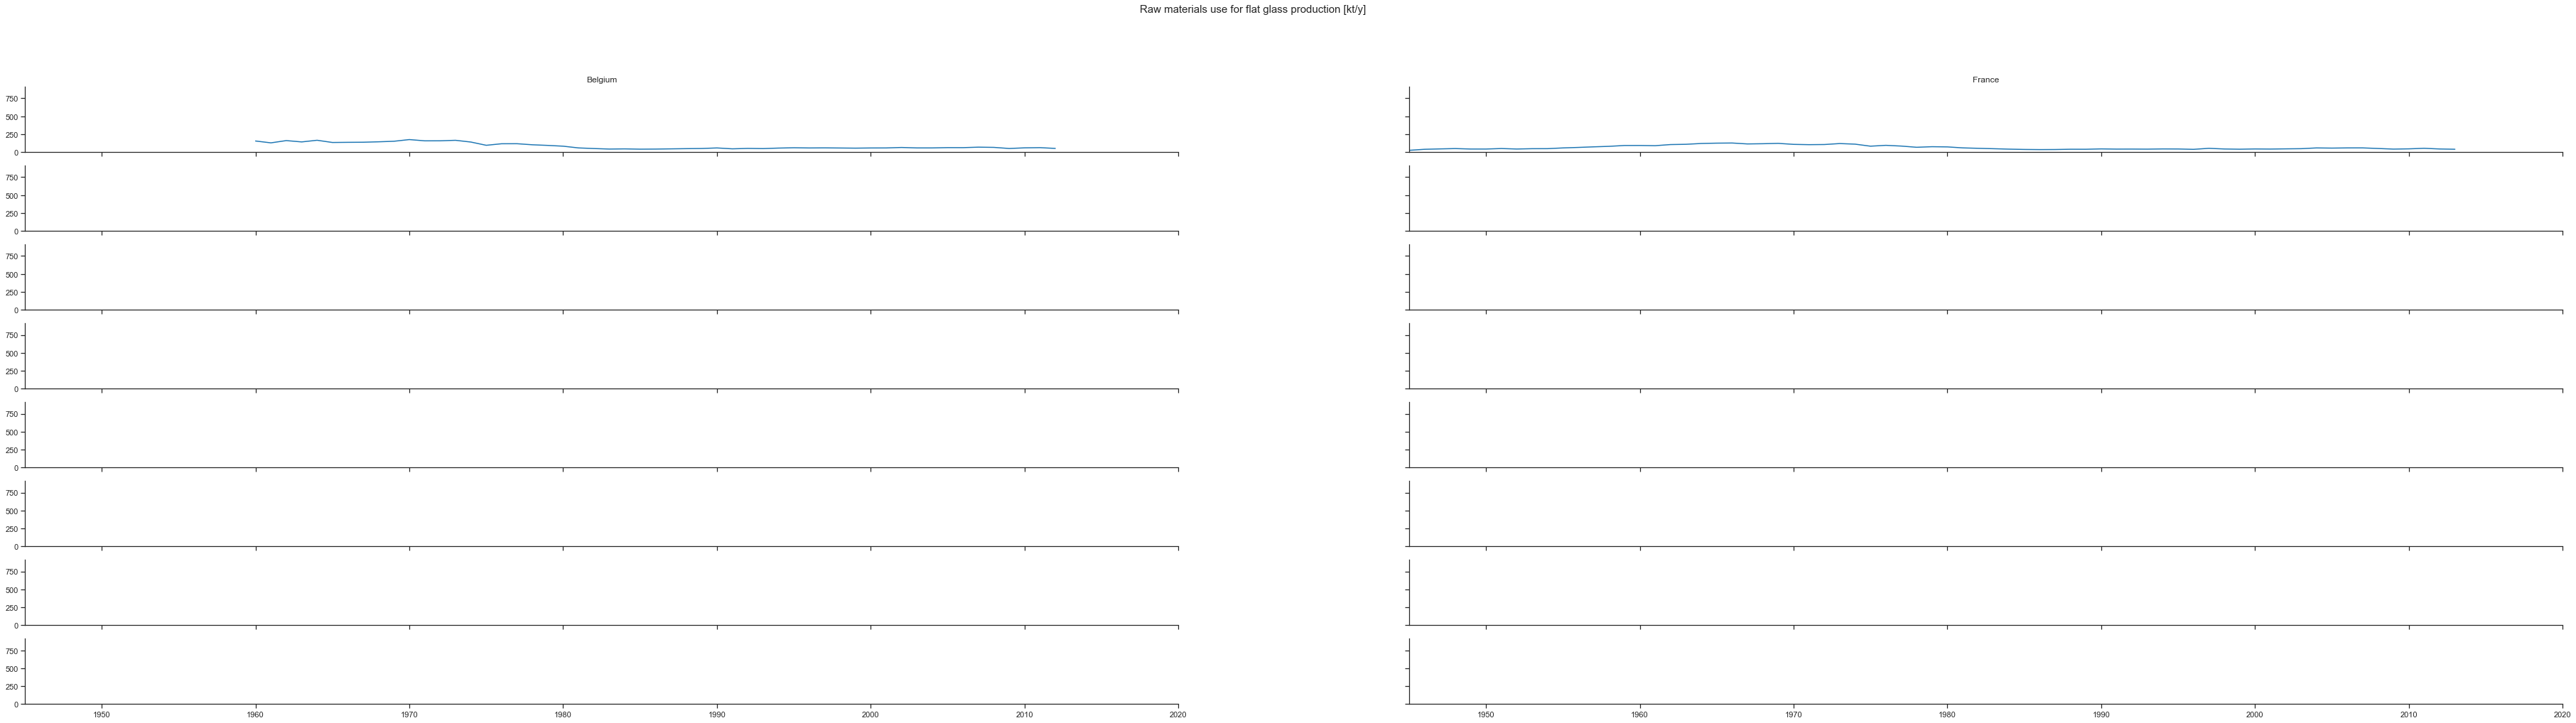

In [44]:
fig, axes = plt.subplots(nrows=8, ncols=2, 
                         figsize=(64, 16), 
                         sharex=True, sharey=True)

for i, (ax, col) in enumerate(zip(axes.flatten(), 
                                  BE_FR['Production [kt]'].columns)):

    ax.plot(BE_FR['Int. cullet, flat glass [kt]'].index, 
            BE_FR['Int. cullet, flat glass [kt]'][col],
            BE_FR['Ext. cullet, flat glass [kt]'][col], 
            BE_FR['Sand, flat glass [kt]'][col])
    
    ax.set_title(col)
    ax.set_xlim(1945,2020)
    ax.set_ylim(ymin=0)
    
fig.suptitle('Raw materials use for flat glass production [kt/y]', 
             fontsize = 15)
sns.despine()
plt.show()

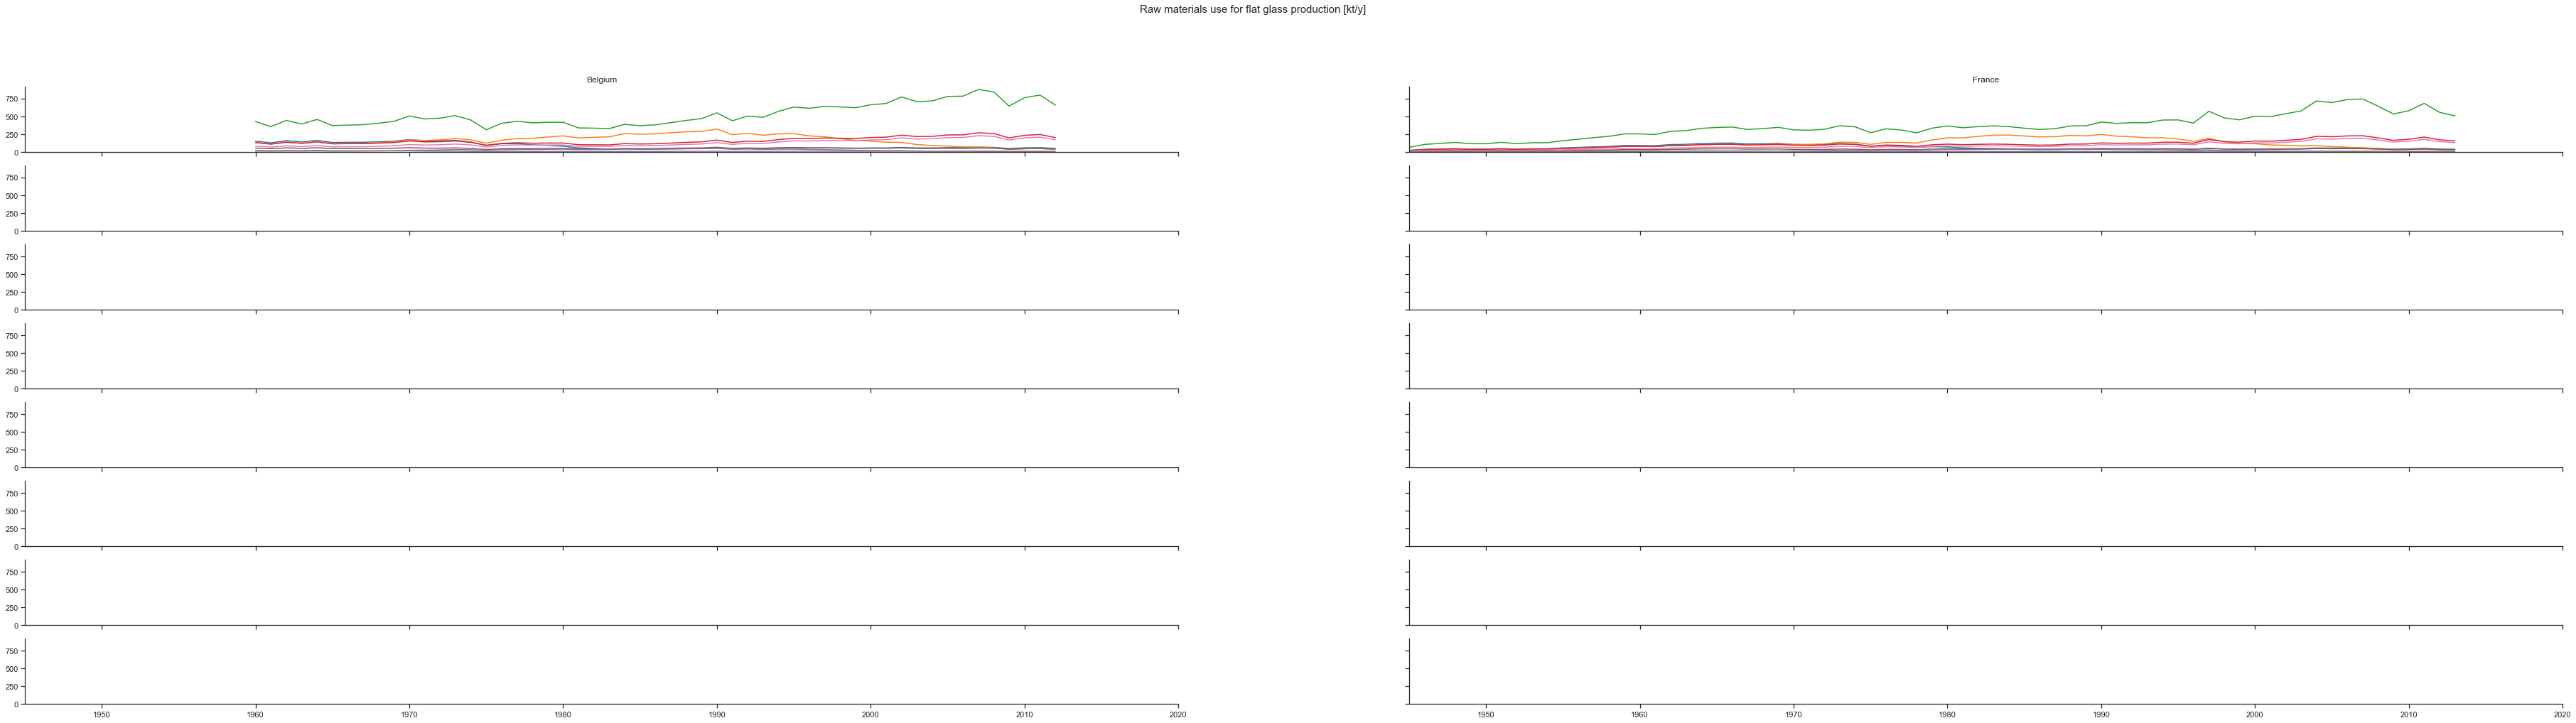

In [45]:
fig, axes = plt.subplots(nrows=8, ncols=2, 
                         figsize=(64, 16), 
                         sharex=True, sharey=True)

for i, (ax, col) in enumerate(zip(axes.flatten(), 
                                  BE_FR['Production [kt]'].columns)):

    ax.plot(BE_FR['Int. cullet, flat glass [kt]'].index, 
            BE_FR['Int. cullet, flat glass [kt]'][col])
    ax.set_title(col)

for i, (ax, col) in enumerate(zip(axes.flatten(), 
                                  BE_FR['Production [kt]'].columns)):
    ax.plot(BE_FR['Ext. cullet, flat glass [kt]'].index, 
            BE_FR['Ext. cullet, flat glass [kt]'][col])
    ax.set_title(col)

for i, (ax, col) in enumerate(zip(axes.flatten(), 
                                  BE_FR['Production [kt]'].columns)):
    ax.plot(BE_FR['Sand, flat glass [kt]'].index, 
            BE_FR['Sand, flat glass [kt]'][col])
    ax.set_title(col)

for i, (ax, col) in enumerate(zip(axes.flatten(), 
                                  BE_FR['Production [kt]'].columns)):
    ax.plot(BE_FR['Sodium carbonate, flat glass [kt]'].index, 
            BE_FR['Sodium carbonate, flat glass [kt]'][col])
    ax.set_title(col)

for i, (ax, col) in enumerate(zip(axes.flatten(), 
                                  BE_FR['Production [kt]'].columns)):
    ax.plot(BE_FR['Sodium sulfate, flat glass [kt]'].index, 
            BE_FR['Sodium sulfate, flat glass [kt]'][col])
    ax.set_title(col)

for i, (ax, col) in enumerate(zip(axes.flatten(), 
                                  BE_FR['Production [kt]'].columns)):
    ax.plot(BE_FR['Limestone, flat glass [kt]'].index, 
            BE_FR['Limestone, flat glass [kt]'][col])
    ax.set_title(col)

for i, (ax, col) in enumerate(zip(axes.flatten(), 
                                  BE_FR['Production [kt]'].columns)):
    ax.plot(BE_FR['Dolomite, flat glass [kt]'].index, 
            BE_FR['Dolomite, flat glass [kt]'][col])
    ax.set_title(col)

for i, (ax, col) in enumerate(zip(axes.flatten(), 
                                  BE_FR['Production [kt]'].columns)):
    ax.plot(BE_FR['Feldspar, flat glass [kt]'].index, 
            BE_FR['Feldspar, flat glass [kt]'][col])
    
    ax.set_title(col)
    ax.set_xlim(1945,2020)
    ax.set_ylim(ymin=0)
    
fig.suptitle('Raw materials use for flat glass production [kt/y]', 
             fontsize = 15)
sns.despine()
plt.show()

## Energy Use in the production of flat glass

In [46]:
# Total energy
for country in BE_FR['Production [kt]'].columns:
    BE_FR[('Total energy, flat glass [GJ]', country)] = (
        BE_FR[('Production [kt]', country)]
        * MatIntensity['Total energy, GJ/t']*1000
    )
    
# Fuel
for country in BE_FR['Production [kt]'].columns:
    BE_FR[('Fuel, flat glass [GJ]', country)] = (
        BE_FR[('Production [kt]', country)]
        * MatIntensity['Total energy, GJ/t']*1000
        * MatIntensity['fuel, %']
    )
    
# Electricity
for country in BE_FR['Production [kt]'].columns:
    BE_FR[('Electricity, flat glass [GJ]', country)] = (
        BE_FR[('Production [kt]', country)]
        * MatIntensity['Total energy, GJ/t']*1000
        * MatIntensity['electricity, %']
    )
    
# Natural gas
for country in BE_FR['Production [kt]'].columns:
    BE_FR[('Natural gas, flat glass [GJ]', country)] = (
        BE_FR[('Production [kt]', country)]
        * MatIntensity['Total energy, GJ/t']*1000
        * MatIntensity['natural gas, %']
    )

# Insulated glazing flows in France

In [47]:
# Creating a new DataFrame for French IGU
FR_IGU = FR_Prod[['IGU, "000 m²']]
FR_IGU = FR_IGU.rename(columns={'IGU, "000 m²':'prod ["000 m²]'})

FR_IGU['import ["000 m²]'] = FR_Imp['IGU, "000 m²']
FR_IGU['export ["000 m²]'] = FR_Exp['IGU, "000 m²']

FR_IGU['consumption ["000 m²]'] \
    = FR_IGU['prod ["000 m²]'] + FR_IGU['import ["000 m²]'] \
    - FR_IGU['export ["000 m²]']

FR_IGU[-10:]

,"prod [""000 m²]","import [""000 m²]","export [""000 m²]","consumption [""000 m²]"
year,,,,
2011,16997.708,952.462,405.729,17544.441
2012,16424.399,628.725,429.054,16624.070
2013,15763.493,627.096,462.902,15927.687
2014,15000.332,555.118,498.605,15056.845
2015,15062.705,387.240,476.730,14973.215
2016,15192.061,346.616,507.427,15031.250
2017,15696.879,321.060,630.420,15387.519
2018,16462.590,437.020,651.881,16247.729
2019,17206.730,413.427,820.091,16800.066


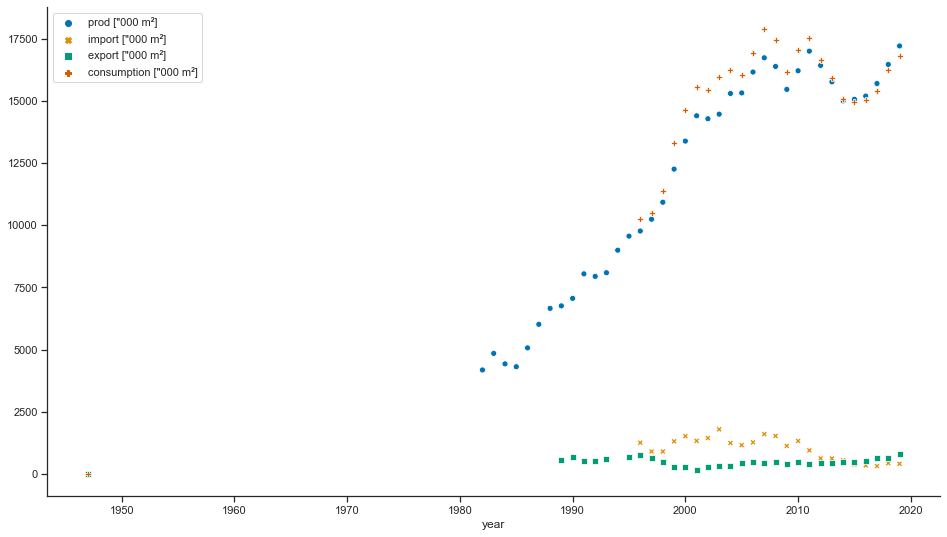

In [48]:
sns.scatterplot(data=FR_IGU, palette='colorblind')
sns.despine()
plt.show()

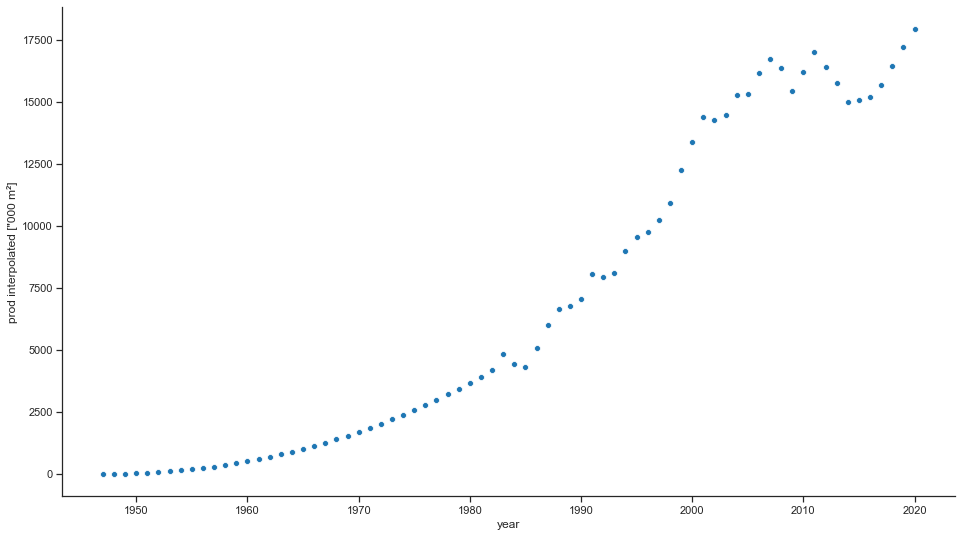

In [49]:
FR_IGU['prod interpolated ["000 m²]'] = FR_IGU['prod ["000 m²]'].interpolate(method = 'pchip')

toplot = FR_IGU.reset_index()
sns.scatterplot(data=toplot, x='year', y='prod interpolated ["000 m²]')
sns.despine()
plt.show()

In [50]:
# Estimating consumption/production ratio over the period 1995-2000
FR_IGU['consumption/production [-]'] \
    = FR_IGU['consumption ["000 m²]'] / FR_IGU['prod ["000 m²]']

a = FR_IGU.loc[1995:2000, 'consumption/production [-]'].mean().round(2)
print("Mean consumption/production ratio, 1995-2000:", a)

FR_IGU['consumption/production [-]'][1945] = 0
FR_IGU.head()

Mean consumption/production ratio, 1995-2000: 1.06


,"prod [""000 m²]","import [""000 m²]","export [""000 m²]","consumption [""000 m²]","prod interpolated [""000 m²]",consumption/production [-]
year,,,,,,
1945,NaN,NaN,NaN,NaN,NaN,0.0
1946,NaN,NaN,NaN,NaN,NaN,NaN
1947,0.0,0.0,0.0,0.0,0.000000,NaN
1948,NaN,NaN,NaN,NaN,2.847768,NaN
1949,NaN,NaN,NaN,NaN,11.457867,NaN


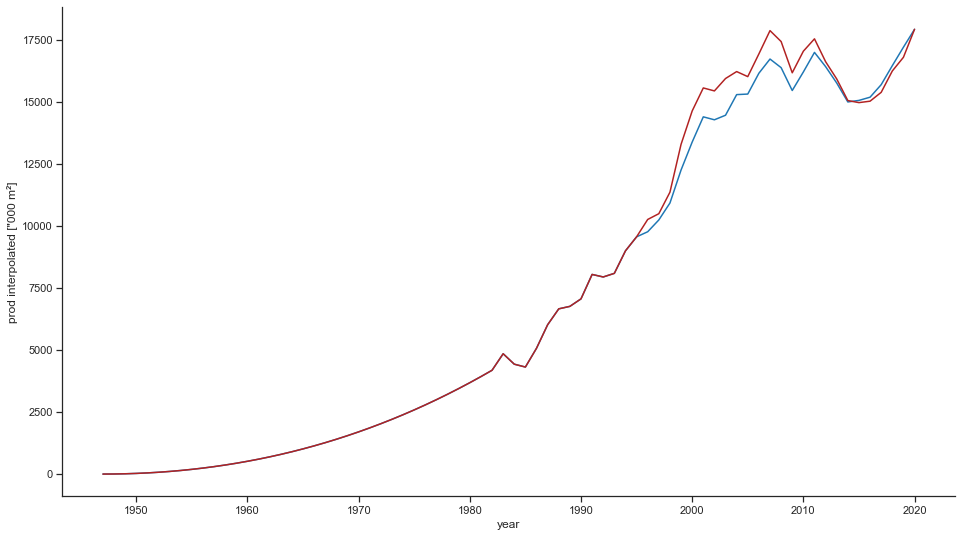

In [51]:
# Estimating consumption since 1945
filt_null = FR_IGU['consumption ["000 m²]'].isnull()

FR_IGU.loc[filt_null, 'consumption ["000 m²]'] \
    = FR_IGU.loc[filt_null, 'prod interpolated ["000 m²]']

FR_IGU = FR_IGU.reset_index()

fig, ax = plt.subplots()

# lineplot is useless here. In fact you should use dataframe.plot() for both...
sns.lineplot(data=FR_IGU, x='year', y='prod interpolated ["000 m²]',
             ax=ax, palette='Reds')

ax.plot(FR_IGU['year'], FR_IGU['consumption ["000 m²]'], color='firebrick')

FR_IGU = FR_IGU.set_index('year')
sns.despine()
plt.show()

Text(0.5, 0.98, 'IGU (rolled) [kt/y]')

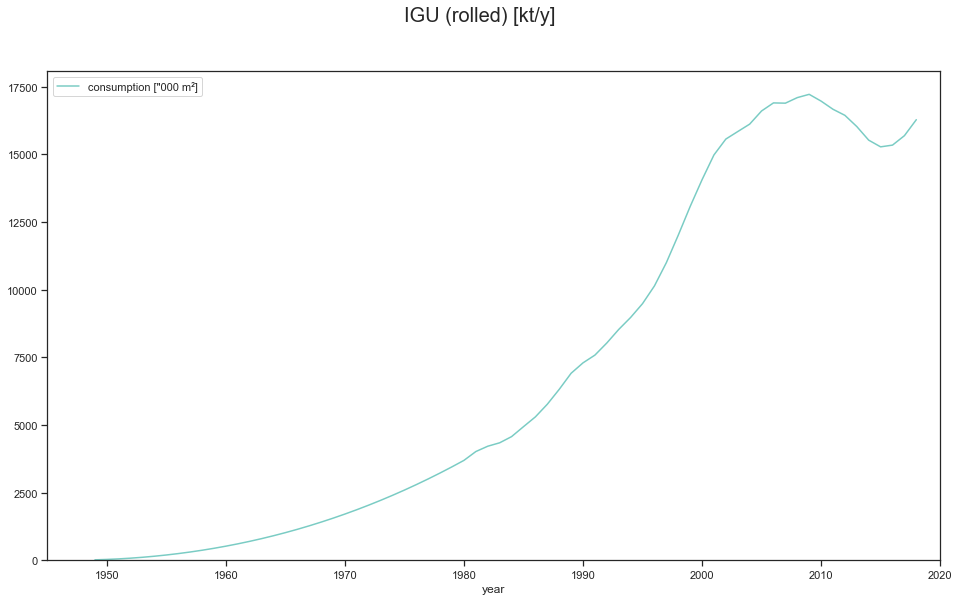

In [52]:
# Rolling IGU consumption data according to a 5-year mean
FR_IGU_roll = FR_IGU[['consumption ["000 m²]']].copy()

win_len = 5
FR_IGU_roll = FR_IGU_roll.rolling(win_len, center = True).mean()

# Plotting results, to be compared with above graph
fig, ax = plt.subplots()

sns.lineplot(data = FR_IGU_roll, palette="GnBu")

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)

fig.suptitle('IGU (rolled) [kt/y]', 
             fontsize = 20)

## c. CO2 emissions relating to IGU consumption in FR

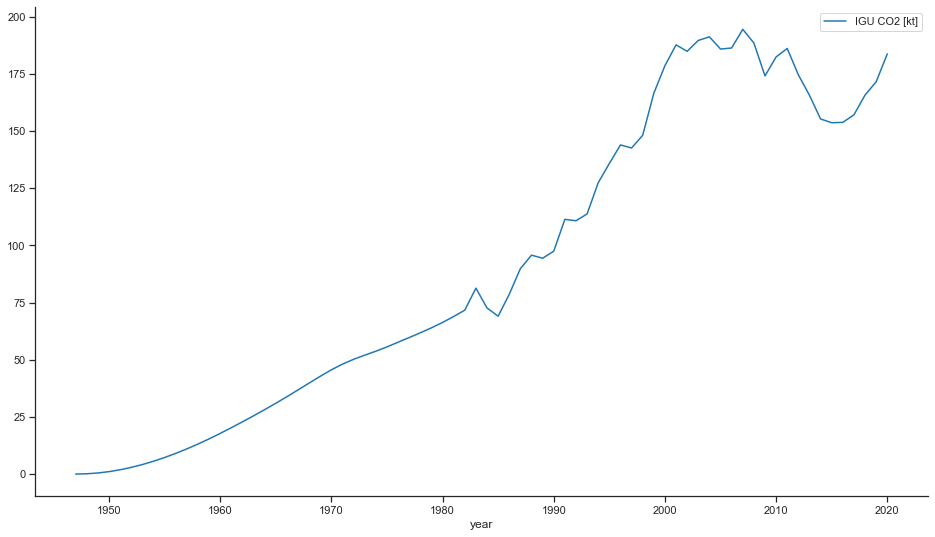

In [53]:
# Hypothesis: The average thickness of an IGU is twice 4mm, 
# i.e., 8mm of glass, which equals 20kg per m²
FR_IGU['consumption [kt]'] = FR_IGU['consumption ["000 m²]'] * 20 / 1000

# Absolute CO2 emissions in France
CO2_IGU = FR_IGU['consumption [kt]'] \
    * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000

CO2_IGU = pd.DataFrame(CO2_IGU, columns = ['IGU CO2 [kt]'])

# Plotting
sns.lineplot(data = CO2_IGU)

sns.despine()
plt.show()

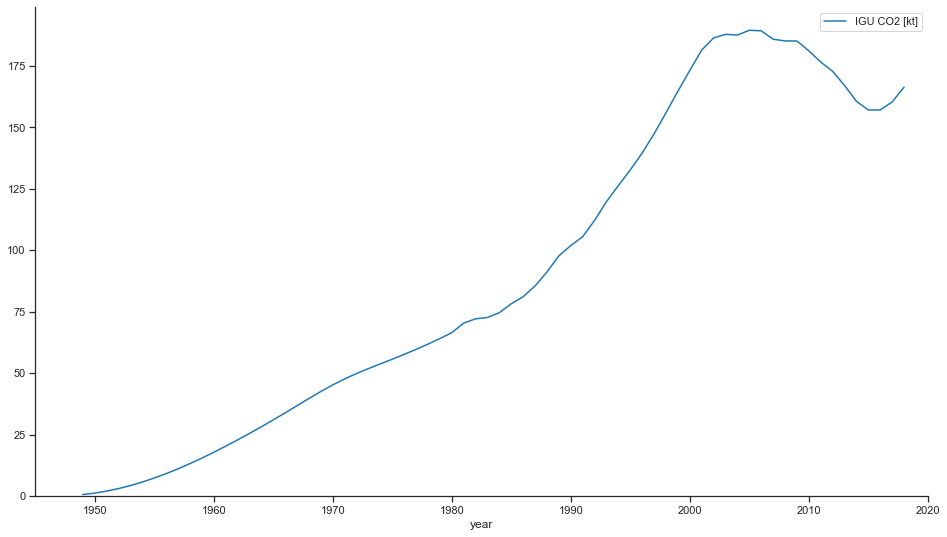

In [54]:
# Rolling CO2 emissions of IGU according to a 5-year mean
win_len = 5
CO2_IGU_roll = CO2_IGU.rolling(win_len, center = True).mean()

# Plotting
fig, ax = plt.subplots()

sns.lineplot(data = CO2_IGU_roll)

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

NameError: name 'CO2Intensity_diff_noroll' is not defined

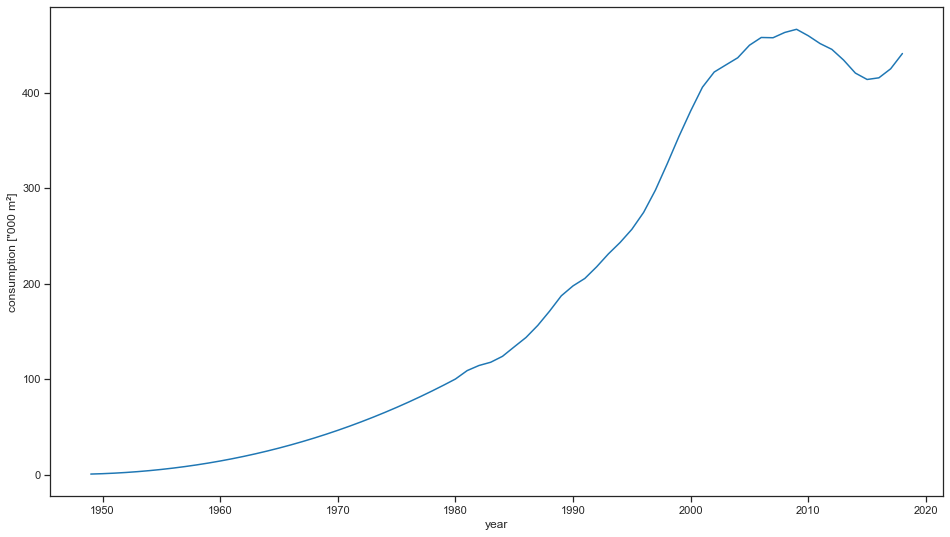

In [55]:
# Base 100 = 1990
CO2_IGU_diff_roll = 100 * CO2_IGU_roll / CO2_IGU_roll.loc[1980]
FR_IGU_diff_roll = 100 * FR_IGU_roll / FR_IGU_roll.loc[1980]

# Plotting consumption, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots()

sns.lineplot(data = FR_IGU_diff_roll, 
             x = FR_IGU_diff_roll.index, 
             y = 'consumption ["000 m²]',
             palette = "GnBu")

ax.plot(CO2Intensity_diff_noroll.index, 
        CO2Intensity_diff_noroll['CO2 interpolated [kg/t]'])
ax.plot(CO2_IGU_diff_roll.index, 
        CO2_IGU_diff_roll['IGU CO2 [kt]'])

ax.plot([1980, 2020], [100, 100], '--')

ax.set_xlim(1980,2020)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

# 3. Postprocessing of the European dataset

## a. Production of flat glass

In [ ]:
EU_Prod = EU_data.parse('prod').set_index(['Nbr of countries', 'year'])
EU_Prod

In [ ]:
# Plot the European production of flat glass

EUplot = EU_Prod.reset_index()

fig, ax = plt.subplots()

sns.lineplot(data = EUplot, x = 'year', y = 'flat glass, kt', 
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
fig.suptitle('European production of flat glass [kt/y]', fontsize = 20)
sns.despine()
plt.show()

In [ ]:
# Adding import and export in order to estimate consumption in EU
EU_Imp = EU_data.parse('import').set_index(['Nbr of countries', 'year'])
EU_Exp = EU_data.parse('export').set_index(['Nbr of countries', 'year'])

# Estimating consumption in EU
EU_Consumption = EU_Prod.reset_index()[['Nbr of countries', 
                                        'year']].set_index(['Nbr of countries', 
                                                            'year'])
EU_Consumption['flat glass, kt'] = EU_Prod['flat glass, kt'] \
    + EU_Imp['flat glass, kt'] - EU_Exp['flat glass, kt']

# Plot the European consumption of flat glass

EUplot = EU_Consumption.reset_index()

fig, ax = plt.subplots()

sns.lineplot(data = EUplot, x = 'year', y = 'flat glass, kt', 
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
fig.suptitle('European consumption of flat glass [kt/y]', fontsize = 20)
sns.despine()
plt.show()

## c. Production of architectural flat glass

In [ ]:
# Share of building glazing in the European production of flat glass
EUBldgShare = EU_Prod[['bldg glass/flat glass, %']]

ShareEU = EUBldgShare.dropna()
ShareEU

In [ ]:
toplot = EUBldgShare.reset_index()

fig, ax = plt.subplots()

sns.lineplot(data=toplot, x='year', y='bldg glass/flat glass, %', 
             markers="o", ax=ax)

ax.lines[0].set_linestyle("--")
ax.set_xlim(1945,2020)
ax.set_ylim(0,1)

In [ ]:
EUBldgShare

In [ ]:
# Estimating parameters a, b and c; 2-degree polynomial
values = np.polyfit(x=ShareEU.index.get_level_values(0), 
                  y=ShareEU['bldg glass/flat glass, %'], 
                  deg=2, full=True) 

values

In [ ]:
# Interpolation according to values calculated above
EUBldgShare.loc[1970:2020, 'bldg glass/flat glass (interpolated) [%]'] \
    = values[0][0] * EUBldgShare.index(0) ** 2\
    * values[0][1] * EUBldgShare.index(0) \
    * values[0][2] * EUBldgShare.index(0)

EUBldgShare[-50:]

In [ ]:
fig, ax = plt.subplots()

sns.scatterplot(data=EUBldgShare,
                x='year', 
                y='bldg glass/flat glass (interpolated) [%]',
                ax=ax)

ax.lines[0].set_linestyle("--")
ax.set_xlim(1945,2020)
ax.set_ylim(0,1)